**CNN avec Spectrogramme sur corpus glides**


Afin de pouvoir comparer équitablement les deux entrées ( spectro vs modulation ), les deux modèles sont identiques. 


Importation des bibliothèques

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D, Conv2D
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import glob
import csv
from sklearn.metrics import confusion_matrix

Importation du corpus train et test pour la classe malade et sain

In [2]:
list_malade = glob.glob('malade_spectro_glides/test/*')
list_ok = glob.glob('sain_spectro_glides/test/*')
img_rows=28
img_cols=28
x_test = []  
y_test = []

dico = {'malade': 0, 'non_malade': 1}
#test
for path in list_malade:
    x=cv2.imread(path,0).astype(np.uint8)
    x=cv2.resize(x,(img_rows,img_cols))
    y = dico['malade']
    x_test.append(x)
    y_test.append(y)

for path in list_ok:
    x=cv2.imread(path,0).astype(np.uint8)
    x=cv2.resize(x,(img_rows,img_cols))
    y = dico['non_malade']
    x_test.append(x)
    y_test.append(y)


#train

list_malade_train = glob.glob('malade_spectro_glides/train/*')
list_ok_train = glob.glob('sain_spectro_glides/train/*')

x_train = []
y_train = []


for path in list_malade_train:
    x = cv2.imread(path, 0).astype(np.uint8)
    x = cv2.resize(x, (img_rows, img_cols))
    y = dico['malade']
    x_train.append(x)
    y_train.append(y)

for path in list_ok_train:
    x = cv2.imread(path, 0).astype(np.uint8)
    x = cv2.resize(x, (img_rows, img_cols))
    y = dico['non_malade']
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = x_train.reshape(-1, img_rows, img_cols, 1)
x_test = x_test.reshape(-1, img_rows, img_cols, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Définition de la fonction sheduler permettant de faire évoluer le taux d'apprentissage en fonction du nombre d'epoch

In [6]:
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 30:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.5
    return lr

Initialisation du modèle

In [6]:
model = Sequential()
model.add(Conv2D(512, kernel_size=(2, 2), activation='relu', input_shape=(img_rows, img_cols, 1), padding='same'))
model.add(BatchNormalization())
value_top = 0
value_bottom = 0
value_left = 0
value_right = 0
model.add(ZeroPadding2D(padding=((value_top, value_bottom), (value_left, value_right))))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 512)       2560      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 512)       2048      
 Normalization)                                                  
                                                                 
 zero_padding2d (ZeroPaddin  (None, 28, 28, 512)       0         
 g2D)                                                            
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       524544    
                                                      

Lancement de l'entrainement et de l'évaluation.

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=3, patience=35)
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=25, epochs=70, verbose=1, validation_split=0.2, callbacks=[es, lr_scheduler])
model.save('model.h5')
score=model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/70
19/19 [==============================] - 2s 52ms/step - loss: 0.0430 - accuracy: 0.9767 - val_loss: 0.2771 - val_accuracy: 0.9076 - lr: 1.0000e-04
Epoch 2/70
19/19 [==============================] - 1s 45ms/step - loss: 0.0451 - accuracy: 0.9789 - val_loss: 0.5859 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 3/70
19/19 [==============================] - 1s 44ms/step - loss: 0.0583 - accuracy: 0.9852 - val_loss: 0.2848 - val_accuracy: 0.9076 - lr: 1.0000e-04
Epoch 4/70
19/19 [==============================] - 1s 44ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.1128 - val_accuracy: 0.9748 - lr: 1.0000e-04
Epoch 5/70
19/19 [==============================] - 1s 43ms/step - loss: 0.0216 - accuracy: 0.9915 - val_loss: 0.1623 - val_accuracy: 0.9496 - lr: 1.0000e-04
Epoch 6/70
19/19 [==============================] - 1s 43ms/step - loss: 0.0505 - accuracy: 0.9810 - val_loss: 0.2575 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 7/70
19/19 [==============================] - 

Nous arrivons à 75 pourcents ce qui est plutôt bon ! Lancement de la prédiction sur le corpus test.

6/6 [==============================] - 0s 20ms/step


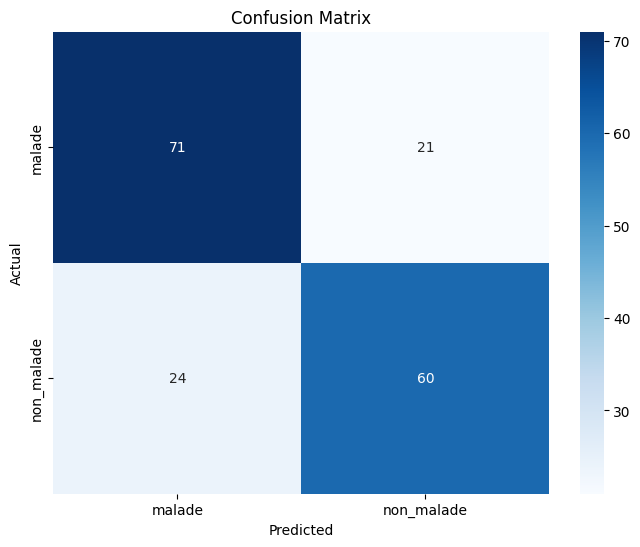

In [19]:
y_pred_probs = model.predict(x_test)
#print(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Enregistrement des mauvaises prédictions dans un fichier CSV

In [20]:

misclassified_data = []

for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        actual_class = 'malade' if y_test[i] == 0 else 'non_malade'
        predicted_class = 'malade' if y_pred[i] == 0 else 'non_malade'
        image_name = os.path.basename(list_malade[i]) if i < len(list_malade) else os.path.basename(list_ok[i - len(list_malade)])
        
        misclassified_data.append([image_name, actual_class, predicted_class])

csv_file_path = 'mal_class_glides_spectro.csv'
header = ['Image Name', 'Actual Class', 'Predicted Class']

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(misclassified_data)

print(f"c'est save :D {csv_file_path}")
import pandas as pd
res=pd.DataFrame(misclassified_data)
print(res)

c'est save :D mal_class_glides_spectro.csv
                                                    0           1           2
0   spectrogram_SCA_F_AB30_2020_11_26_ModuleTransi...      malade  non_malade
1   spectrogram_SCA_F_AB30_2020_11_26_ModuleTransi...      malade  non_malade
2   spectrogram_SCA_F_AB31_2020_11_26_ModuleTransi...      malade  non_malade
3   spectrogram_SCA_F_AB31_2020_11_26_ModuleTransi...      malade  non_malade
4   spectrogram_SCA_H_AB25_2020_11_13_ModuleTransi...      malade  non_malade
5   spectrogram_SCA_H_AB25_2020_11_13_ModuleTransi...      malade  non_malade
6   spectrogram_SCA_H_AB25_2020_11_13_ModuleTransi...      malade  non_malade
7   spectrogram_SCA_H_AB25_2020_11_13_ModuleTransi...      malade  non_malade
8   spectrogram_SCA_H_AB36_2020_02_04_ModuleTransi...      malade  non_malade
9   spectrogram_SCA_H_AB36_2020_02_04_ModuleTransi...      malade  non_malade
10  spectrogram_SCA_H_AB36_2020_02_04_ModuleTransi...      malade  non_malade
11  spectrogram_SCA_H

Ce qui est intéressant ici c'est que le modèle classe les deux classes avec quasiment le même nombre d'erreur contrairement au CNN qui lui favorise les malades. Nous pouvons encore remarquer qu'il classe mal pour les malades les personnes avec une sévrité très basse. Neanmoins il classe aussi mal ceux qui sont moyennement sévère ce qui lui donne de moins bonnes performances que le CNN. L'input doit être sujet à plus de bruit et embrouiller le modèle lors de sa prise décision. Des graphiques montrant les les mauvaises prédictions sont disponibles sur le git.

Voici les essais moins concluants avec tanh et softmax.

In [4]:
model = Sequential()
model.add(Conv2D(512, kernel_size=(2, 2), activation='tanh', input_shape=(img_rows, img_cols, 1), padding='same'))
model.add(BatchNormalization())
value_top = 0
value_bottom = 0
value_left = 0
value_right = 0
model.add(ZeroPadding2D(padding=((value_top, value_bottom), (value_left, value_right))))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (2, 2), activation='tanh', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (2, 2), activation='tanh', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 512)       2560      
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 512)       2048      
 chNormalization)                                                
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 28, 28, 512)       0         
 ing2D)                                                          
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 512)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 256)       524544    
                                                      

Epoch 1/70
19/19 [==============================] - 2s 55ms/step - loss: 0.1412 - accuracy: 0.9471 - val_loss: 0.2524 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 2/70
19/19 [==============================] - 1s 46ms/step - loss: 0.1488 - accuracy: 0.9493 - val_loss: 0.1526 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 3/70
19/19 [==============================] - 1s 44ms/step - loss: 0.1731 - accuracy: 0.9366 - val_loss: 0.4013 - val_accuracy: 0.8487 - lr: 1.0000e-04
Epoch 4/70
19/19 [==============================] - 1s 46ms/step - loss: 0.1743 - accuracy: 0.9408 - val_loss: 0.1682 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 5/70
19/19 [==============================] - 1s 46ms/step - loss: 0.1748 - accuracy: 0.9323 - val_loss: 0.1942 - val_accuracy: 0.9496 - lr: 1.0000e-04
Epoch 6/70
19/19 [==============================] - 1s 44ms/step - loss: 0.1875 - accuracy: 0.9112 - val_loss: 0.1007 - val_accuracy: 0.9664 - lr: 1.0000e-04
Epoch 7/70
19/19 [==============================] - 

C:\Users\Natou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 21ms/step - loss: 1.5767 - accuracy: 0.7045
Test loss: 1.5767054557800293
Test accuracy: 0.7045454382896423
6/6 [==============================] - 0s 19ms/step


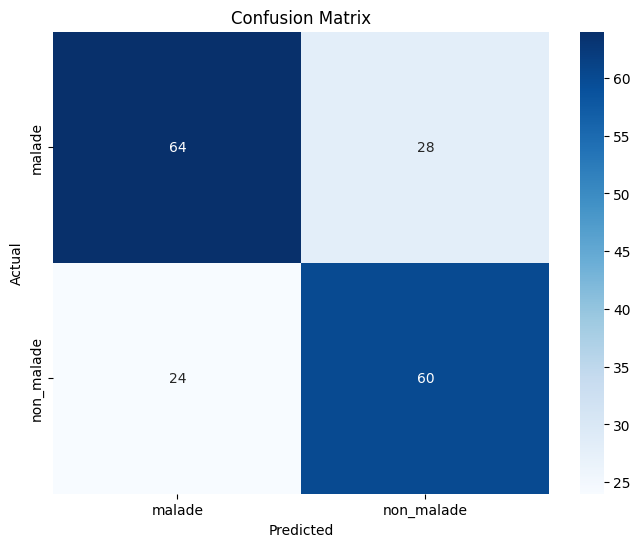

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=3, patience=35)
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=25, epochs=70, verbose=1, validation_split=0.2, callbacks=[es, lr_scheduler])
model.save('model.h5')
score=model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_probs = model.predict(x_test)
#print(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Les résultats sont inférieurs de 5 % avec ces paramètres.